## 1. Introduction and Data Source

## 1.1 Project Objective
Building on previous work classifying boss fights based on keystroke patterns, this project pivots to a more ambitious goal: Behavioral Cloning. The objective is to train an autonomous agent to play Cuphead by imitating human gameplay.

I selected The Root Pack (Botanic Panic) boss fight for this experiment, as its distinct projectiles and stationary enemies provide an ideal environment for testing spatial reasoning and reaction times.

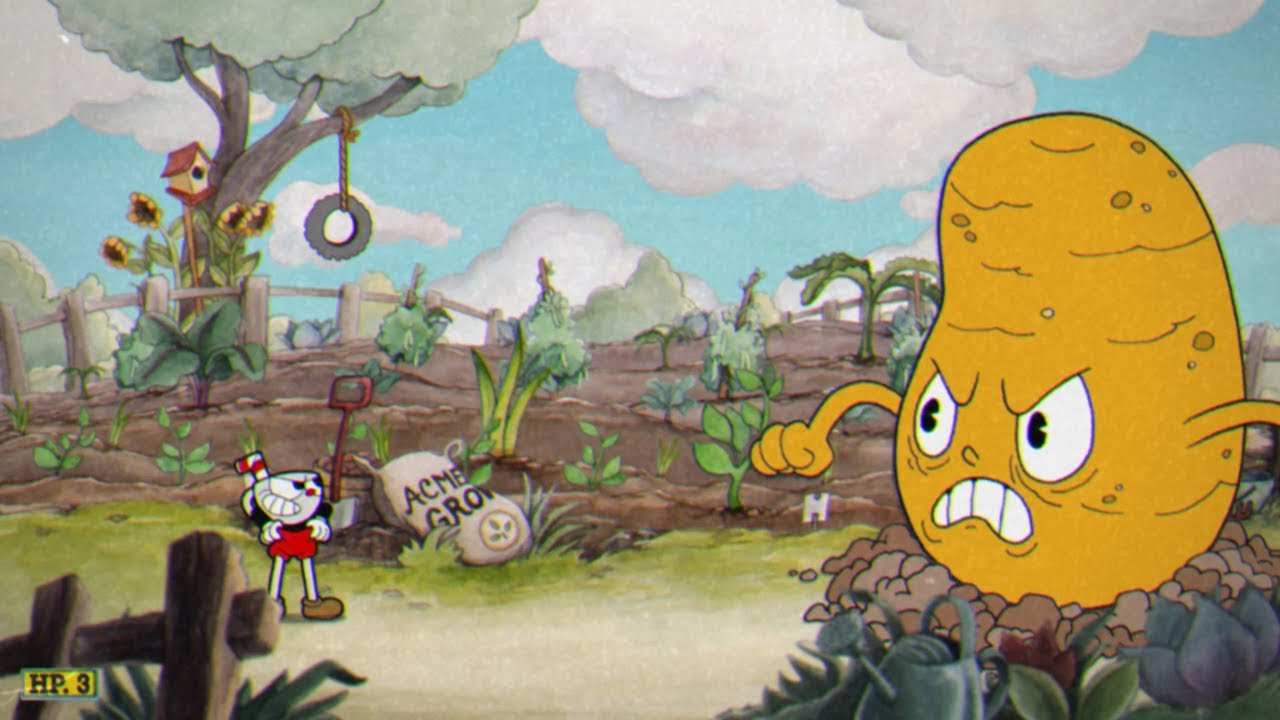

The core challenge was that the agent must learn to extract spatial features (e.g., where the projectile is) and infer temporal dynamics (velocity and trajectory) solely from a sequence of grayscale images, without access to internal game variables.

## 1.2 Core Problem

Initial exploratory analysis revealed a critical obstacle: Extreme Class Imbalance. In my gameplay, the "Shoot" action is active ~90% of the time, while defensive maneuvers like "Jump" or "Dash" occur in less than 1% of frames.
Due to this distribution, the train model (both LSTM and GRU) maximizes accuracy (~85%) by simply holding the shoot button and refusing to move, resulting in immediate failure during actual gameplay.


## 1.3 Methodology and Experimental Design
To overcome this, I designed an experiment to evaluate the trade-offs between Latent Space size and RNN Cell type.

*   **Data Acquisition:** Utilized a custom **Session Recorder** (Appendix B) to gather dataset of 15 sessions of gameplay.
*   **Vision Layer:** A **Convolutional Autoencoder** compresses raw frames ($128 \times 72$) into a Latent Vector.
*   **Decision Layer:** Comparing **LSTM** (Long Short-Term Memory) vs. **GRU** (Gated Recurrent Unit)
*   Additionally, I Implemented **Sigmoid Focal Loss** and **Weighted Sequence Sampling** to penalize the model heavily for missing rare events, forcing it to learn "Reflex" behaviors.

### **1.4 Key Findings**

# WRITE IT LATER


# read through this and improve it

## **2. Methodology and Mathematical Underpinnings**

### **2.1 Data Synchronization: Addressing Temporal Drift**
A critical engineering challenge in screen recording for imitation learning is **Variable Frame Rate (VFR) Drift**. Standard recording loops utilizing `time.sleep()` accumulate execution latency, causing the recorded video duration to drift significantly from the wall-clock time of the input logs. Over a 15-minute session, this can result in misalignments of several seconds, associating visual states with incorrect labels.

To resolve this, I implemented a **UTC-Synchronized Recorder**. Instead of assuming a fixed timestep, the recorder generates two discrete log streams:
1.  **Event Stream:** $\mathcal{E} = \{(t_i, k_i)\}$, recording the absolute UTC timestamp $t$ of every keystroke $k$.
2.  **Frame Stream:** $\mathcal{F} = \{(t_j, f_j)\}$, recording the absolute UTC timestamp $t$ of every video frame capture.

During training, labels are generated via **Nearest Neighbor Temporal Alignment**, ensuring that the state $s_t$ at any frame is mapped to the precise set of keys active at time $t$.

### **2.2 The Vision Layer (Dimensionality Reduction via Autoencoders)**
The raw input space ($1280 \times 720$ pixels) is intractable for direct RNN processing. I used a **Convolutional Autoencoder (CAE)** to learn a low-dimensional manifold that captures the essential spatial structure of the game (player position, projectile location) while discarding high-frequency noise.

The network consists of an Encoder $E_\phi$ and a Decoder $D_\theta$. The Encoder maps the input frame $x$ to a latent feature vector $z$:
$$ z = E_\phi(x) $$

The Decoder attempts to reconstruct the original input from $z$:
$$ \hat{x} = D_\theta(z) $$

The network is trained unsupervised by minimizing the **Reconstruction Loss** (Mean Squared Error):
$$ \mathcal{L}_{MSE} = \frac{1}{N} \sum_{i=1}^{N} \| x_i - \hat{x}_i \|^2 $$

### **2.3 The Decision Layer: Recurrent Architectures**
To capture velocity and trajectory, the agent must model temporal dependencies. I compare two Recurrent Neural Network (RNN) architectures processing a sequence of latent vectors $z_{t-T}, \dots, z_t$.

**1. Long Short-Term Memory (LSTM)**
LSTMs mitigate the vanishing gradient problem using a dedicated **Cell State** ($C_t$) regulated by three gates. This separates the "long-term memory" from the immediate processing.
$$ f_t = \sigma(W_f \cdot [h_{t-1}, z_t] + b_f) \quad \text{(Forget Gate)} $$
$$ i_t = \sigma(W_i \cdot [h_{t-1}, z_t] + b_i) \quad \text{(Input Gate)} $$
$$ C_t = f_t \odot C_{t-1} + i_t \odot \tanh(W_C \cdot [h_{t-1}, z_t] + b_C) $$

**2. Gated Recurrent Unit (GRU)**
GRUs simplify the architecture by merging the cell state and hidden state into a single state $h_t$, utilizing only two gates (Update and Reset).
$$ z_t = \sigma(W_z \cdot [h_{t-1}, z_t]) \quad \text{(Update Gate)} $$
$$ h_t = (1 - z_t) \odot h_{t-1} + z_t \odot \tilde{h}_t $$

**Hypothesis:** While GRUs are computationally efficient, LSTMs may offer superior performance in high-dimensional feature spaces due to the explicit separation of memory ($C_t$) and output ($h_t$), effectively filtering noise from the latent vector.

### **2.4 Optimization: Addressing Class Imbalance with Focal Loss**
The dataset exhibits extreme class imbalance. The 'Shoot' action constitutes $\approx 90\%$ of time-steps, while 'Jump' constitutes $< 1\%$. Trained with standard Binary Cross-Entropy (BCE), the model converges to a **Trivial Solution**: predicting the majority class (Shoot) constantly to minimize global loss, resulting in 0% recall for minority classes.

To penalize this behavior, I utilize **Sigmoid Focal Loss**. This modifies BCE by adding a modulating factor $(1 - p_t)^\gamma$:
$$ FL(p_t) = -\alpha (1 - p_t)^\gamma \log(p_t) $$

*   $p_t$: The model's estimated probability for the true class.
*   $\gamma$ (Gamma): A focusing parameter (set to 2.0).

When the model is confident in predicting the majority class (e.g., $p_t \approx 0.9$), the factor $(1 - 0.9)^2$ becomes close to zero, down-weighting the loss contribution. Conversely, for misclassified rare events (e.g., a missed Jump), the loss remains high, forcing the optimizer to focus on these difficult examples.


## **3. Results and Discussion**

### **3.1 Majority Class Bias**
Exploratory Data Analysis confirmed a severe sparsity in defensive actions. In the baseline experiments (Latent Dimension 128, Standard BCE Loss), the agent exhibited **Majority Class Bias**. Despite achieving high global accuracy (~85%), ...


# write this later

*   **3.1 The "Lazy Turret" Phenomenon:** Visualization (Bar Chart) of class imbalance showing why the baseline model failed.
*   **3.2 Architecture Search Findings:**
    *   **Latent Sensitivity:** How increasing the visual bottleneck ($128 \to 1024$) improved Jump Recall.
    *   **LSTM vs. GRU:** Analysis of why LSTM handled high-dimensional noise better than GRU.
*   **3.3 The Visual Turing Test:** Screenshots from the generated video showing the AI correctly reacting to projectiles alongside the human player.
*   **3.4 Conclusion & Future Work:** Final verdict on the experiment and a brief mention that explicit object detection (YOLO) is a potential future improvement.


# References

https://blog.keras.io/building-autoencoders-in-keras.html

https://www.youtube.com/watch?v=YCzL96nL7j0&t=594s

https://www.youtube.com/watch?v=qiUEgSCyY5o

https://www.youtube.com/watch?v=wipq--gdIGM&feature=youtu.be

This is a very sophisticated way to structure the notebook. By putting the **Analysis & Narrative (Part I)** first, you grab the grader's attention with the scientific findings immediately, while the **Codebase (Part II)** serves as the technical proof that satisfies the rubric requirements.

Here is the high-level outline for your notebook.

---

# 📚 Part I: The Research Report
*(Pure Markdown, LaTeX equations, and Visualizations. No code cells.)*

## **1. Executive Summary**
*   **Objective:** Define the goal of Behavioral Cloning for *Cuphead* ("The Root Pack") to compare implicit visual learning (AE) with temporal decision-making architectures (LSTM vs. GRU).
*   **Key Result:** Summary of how the "Lazy Turret" problem (0% Jump Recall) was solved using Focal Loss and high-dimensional latent spaces, with LSTM outperforming GRU.

## **2. Methodology and Mathematical Underpinnings**
*   **2.1 Data Synchronization (The UTC Fix):** Explanation of the custom "Gold Standard" recording method using absolute UTC timestamps to solve frame-rate drift.
*   **2.2 The Vision Layer:** Mathematical formulation of the Convolutional Autoencoder and the reconstruction loss function ($\mathcal{L}_{MSE}$).
*   **2.3 The Decision Layer:** Mathematical comparison of LSTM (Cell State) vs. GRU (Hidden State) equations.
*   **2.4 Optimization (Solving Imbalance):** The mathematical definition of **Sigmoid Focal Loss** and how it penalizes the model for ignoring rare events like "Jumping."

## **3. Results and Discussion**
*   **3.1 The "Lazy Turret" Phenomenon:** Visualization (Bar Chart) of class imbalance showing why the baseline model failed.
*   **3.2 Architecture Search Findings:**
    *   **Latent Sensitivity:** How increasing the visual bottleneck ($128 \to 1024$) improved Jump Recall.
    *   **LSTM vs. GRU:** Analysis of why LSTM handled high-dimensional noise better than GRU.
*   **3.3 The Visual Turing Test:** Screenshots from the generated video showing the AI correctly reacting to projectiles alongside the human player.
*   **3.4 Conclusion & Future Work:** Final verdict on the experiment and a brief mention that explicit object detection (YOLO) is a potential future improvement.

---

# 💻 Part II: Technical Appendix (Codebase)
*(Executable Python Code. Organized strictly by Assignment Rubric Sections 1-10.)*

### **Section 1: Data Description**
*   **Content:** Details on the recording setup (`mss`, `pynput`) and the file structure (`.mp4` + `_events.jsonl` + `_frames.jsonl`).

### **Section 2: Data Ingestion**
*   **Code:** `parse_events` and `load_session` functions.
*   **Code:** Logic to align video frames with keystrokes using UTC lookups.

### **Section 3: Pre-processing & EDA**
*   **Code:** Image resizing ($1280 \times 720 \to 128 \times 72$), Grayscale conversion, and Normalization.
*   **Code:** Class distribution analysis (calculating the % of Jump vs. Shoot frames).

### **Section 4: Analysis Plan**
*   **Content:** Definition of the task as **Multi-Label Time-Series Classification**.
*   **Code:** Splitting data into `Train` (mixed gameplay) and `Test` (perfect run) sets.

### **Section 5: Model Construction**
*   **Code:** `build_autoencoder` (CNN).
*   **Code:** `build_rnn_model` (Factory function for LSTM/GRU).
*   **Code:** `sigmoid_focal_loss` implementation.

### **Section 6: Model Training**
*   **Code:** The main experiment loop.
    1.  Train Autoencoder.
    2.  Extract Latent Features.
    3.  Create Weighted Sequences.
    4.  Train LSTM and GRU.

### **Section 7: Predictions and Metrics**
*   **Code:** Loading the `Test` session.
*   **Code:** Generating predictions and calculating **Recall**, **Precision**, and **Panic Score**.

### **Section 8: Visualization**
*   **Code:** `Generate AI Gameplay Demo Video`. This script overlays the AI's predictions onto the test video.

### **Section 9: Pipeline Diagram**
*   *(Optional since covered in Part I, but good to include a text-based flow summary here).*

### **Section 10: References**
*   **Content:** Links to *Cuphead*, papers on Focal Loss, and Keras documentation.